## Приняте решения по результатам А/В теста

#### Анализ скидок для сервисов "Жилая недвижимость"
Команда занимается сервисами для владельцев жилой недвижимости и последний год продает клининговые услуги по модели подписки (на месяц и на год). Цены - 200 и 1000 руб. соответственно.\
Решили посмотреть, как скидки влияют на аудиторию. Поделили всех неплативших пользователей, которые заходили в период скидок, на группы А и В. Группе А не давали скидок, а группе В дали скидку 30% на любую из подписок.\
\
Тест проводили с 2019-08-05 до 2019-08-11 включительно, ID теста — 127.\
\
Для подведения итогов А/В-тестирования нужно рассчитать, насколько в группах А и В различаются:
- конверсия (отношение числа покупателей к общему числу пользователей в группе)
- средний чек
- ARPU пользователей (avrage revenue per user - средний доход с одного пользователя)

#### Оглавление
* [1) Загрузить и ознакомиться с данными](#load)
* [2) Проверка статистических гипотез о разности параметров в группах A и B](#hypothesis)
    *  [2.1) Конверсия](#convertion)
    *  [2.2) Средний чек](#avg_bill)
    *  [2.3) ARPU](#arpu)
* [3) Доверительные интервалы](#ci)
* [4) Отчёт](#sum)
* [5) Вывод](#fin)

#### <u>1) Загрузка и ознакомление с данными<a id="load"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.weightstats import ztest
from statsmodels.stats import weightstats

Таблица ab_test_groups

In [2]:
ab_test_groups = pd.read_csv('ab_test_groups.csv')
ab_test_groups.head()

,user_id,grp,ab_test_id
0,1,B,132
1,2,A,132
2,3,B,132
3,4,A,132
4,5,B,132


In [3]:
# Выберем только тест с ID 127
ab_test_groups = ab_test_groups.loc[ab_test_groups.ab_test_id == 127]

Таблица payments

In [19]:
payments = pd.read_csv('payments.csv')
payments.head()

,payment_id,user_id,price,created_at,tariff
0,1,77831,200.0,2019-08-05 00:00:54,month
1,2,84576,200.0,2019-08-05 00:01:05,month
2,3,40981,140.0,2019-08-05 00:03:47,month_30off
3,4,130565,140.0,2019-08-05 00:09:33,month_30off
4,5,34758,700.0,2019-08-05 00:12:16,year_30off


In [20]:
# Только за период 05.08.2019 - 11.08.2019
payments = payments.loc[(payments.created_at >= '2019-08-05') & (payments.created_at < '2019-08-12'),
            ['user_id', 'price']]
payments.head()

,user_id,price
0,77831,200.0
1,84576,200.0
2,40981,140.0
3,130565,140.0
4,34758,700.0


In [21]:
# У одного пользователя может быть несколько покупок - проведем агрегацию по пользователю
payments = payments.groupby('user_id', as_index = False).agg({'price':'sum'})

In [22]:
# Объединяем таблицы
ab_data = ab_test_groups.merge(payments, on = 'user_id', how = 'left')
ab_data.head()

,user_id,grp,ab_test_id,price
0,1,B,127,140.0
1,2,B,127,NaN
2,3,B,127,NaN
3,4,B,127,NaN
4,5,A,127,NaN


Теперь у нас есть информация ab_data о группе А/В-теста для каждого пользователя и о суммарной стоимости его покупок (NaN - пользователь ничего не купил).

Объединим данные в одну таблицу, отражающую число пользователей, число покупателей, конверсию, средний чек, среднюю выручка на пользователя и дополнительная выручка группы B для обеих групп.

In [64]:
# Пользователи
ab_summary = ab_data.groupby('grp').agg({'user_id':'count', 'price':'count'})
# Покупатели
ab_summary.rename(columns={'user_id':'users_count', 'price':'buyers_count'}, inplace = True)
# Конверсия пользователей в покупатели
ab_summary['conversion'] = ab_summary.buyers_count/ab_summary.users_count
# Средниц чек
ab_summary = ab_summary.merge(ab_data.groupby('grp').agg({'price':'mean'}).rename(columns = {'price':'avg_bill'}), left_index = True, right_index = True)
# Выручка на одного пользователя (ARPU)
ab_summary = ab_summary.merge(ab_data.groupby('grp').agg({'price':'sum'}).rename(columns = {'price':'revenue'}), left_index = True, right_index = True)
ab_summary['ARPU'] = ab_summary.revenue/ab_summary.users_count
# Дополнительная выручка группы B
ab_summary['add_rev'] = ab_summary.users_count*(ab_summary.ARPU - ab_summary.loc['A', 'ARPU'])
ab_summary.loc['A', 'add_rev'] = '-'

# Прирост в %
# Пользователи
d = ab_summary.loc['B', 'users_count'] - ab_summary.loc['A', 'users_count']
s = ab_summary.loc['A', 'users_count']
ab_summary['UC, %'] = ['-', f'+{(d*100/s):.1f}']
# Покупатели
d = ab_summary.loc['B', 'buyers_count'] - ab_summary.loc['A', 'buyers_count']
s = ab_summary.loc['A', 'buyers_count']
ab_summary['BC, %'] = ['-', f'+{(d*100/s):.1f}']
# Конверсия
d = ab_summary.loc['B', 'conversion'] - ab_summary.loc['A', 'conversion']
s = ab_summary.loc['A', 'conversion']
ab_summary['C, %'] = ['-', f'+{(d*100/s):.1f}']
# Средний чек
d = ab_summary.loc['B', 'avg_bill'] - ab_summary.loc['A', 'avg_bill']
s = ab_summary.loc['B', 'avg_bill']
ab_summary['AB, %'] = ['-', f'{(d*100/s):.1f}']
# Выручка
d = ab_summary.loc['B', 'revenue'] - ab_summary.loc['A', 'revenue']
s = ab_summary.loc['A', 'revenue']
ab_summary['R, %'] = ['-', f'+{(d*100/s):.1f}']
# ARPU
ab_summary['A, %'] = ['-', f'+{(d*100/s):.1f}']

ab_summary[['users_count', 'UC, %', 'buyers_count', 'BC, %', 'conversion', 'C, %', 'avg_bill', 'AB, %', 'revenue', 'R, %', 'ARPU', 'A, %', 'add_rev']]

C:\Users\user\AppData\Local\Temp\ipykernel_11280\2042953329.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  ab_summary.loc['A', 'add_rev'] = '-'


,users_count,"UC, %",buyers_count,"BC, %",conversion,"C, %",avg_bill,"AB, %",revenue,"R, %",ARPU,"A, %",add_rev
grp,,,,,,,,,,,,,
A,76605,-,4279,-,0.055858,-,396.120589,-,1695000.0,-,22.126493,-,-
B,76627,+0.0,9427,+120.3,0.123025,+120.2,348.804498,-13.6,3288180.0,+94.0,42.911506,+94.0,1592693.217153


Средние значения для групп A и B – это всего лишь средние значения одной из выборок из генеральной совокупности для каждой группы и реальное распределение значений для каждой группы неизвестны. Таким образом, просто так сравнивать их нельзя. Необходимо проверить ститистическую значимость разницы этих показателей.

#### <u>2) Проверка статистических гипотез о разности параметров в группах A и B<a id="hypothesis"></a>

Алгоритм проверки статистических гипотез:
1) Сформулировать статистические гипотезы H0 и H1;
2) Задать уровень значимости $\alpha$ (допустимая вероятность ошибки I-рода);
3) Выбрать статистическоий критерий проверки;
4) Выполнить проверку статистических гипотез с помощью статистического теста;

<b>1)</b> <b>Статистическая гипотеза</b> - предположение о какой-либо характеристике генеральной совокупности, сделанное по выборочным данным (выборки из групп A и B). Статистические гипотезы выдвигаются, когда необходимо проверить, является ли наблюдаемое явление элементом случайности или результатом воздействия некоторых мероприятий.
   - H0: Нулевая гипотеза - обычно указывает на отсутствие статистически значимой разницы в сравниваемых группах (т.е. разница в пределах случайности);
   - H1: Альтернативная гипотеза - обычно утверждает, что различия есть;

<b>2)</b> <b>Уровень значимости</b> $\alpha$ - допустимая вероятность ошибки I-рода или вероятность попадения статистического критерия в критическую область. В качестве уровня значимости обычно выбирается 0.05 (5%) или 0.01 (1%).\
 \
 Ошибки I и II рода:\
  Проверка гипотез осуществляется с помощью статистических критериев. Поскольку H0 выдвигается на основе анализа ВЫБОРОЧНЫХ данных, мы не сможем гарантировать её истинность либо ложность даже после статистической проверки. Однако с помощью статистической проверки гипотез можно определить вероятность принятия ложного решения. Если вероятность последнего невелика, то можно считать, что применяемый критерий обеспечивает малый риск ошибки.\
  \
  Таким образом существует риск (пусть и небольшой) допустить ошибки двух типов:

 - Ошибка I-рода: <i>из-за неполноты выборочных данных или несовершенства статистического критерия</i> гипотеза H0 будет отвергнута, хотя на самом деле в генеральной совокупности она правильная. Вероятность допустить такую ошибку называют уровнем значимости и обозначают буквой $\alpha$.
 
  - Ошибка II-рода: <i>из-за неполноты выборочных данных (попалась неудачная выборка) или несовершенства статистического критерия</i> гипотеза H0 будет принята, но на самом деле  в генеральной совокупности она неправильная. Вероятность совершить эту ошибку обозначают буквой $\beta$.\
  \
  При уменьшении вероятности $\alpha$ (отвергнуть правильную гипотезу) растёт вероятность $\beta$ (принять неверную гипотезу). Чем меньше $\alpha$, тем меньше вероятность браковать проверяемую гипотезу, когда она верна, т.е. меньше вероятность совершить ошибку первого рода. Но при этом расширяется область допустимых значений и, значит, увеличивается вероятность совершения ошибки второго рода.
\
  \
  Пример:\
  H0: конверсии групп A и B равны\
  Ошибка I-рода: из-за неполноты выборочных данных в результате опыта сделал вывод, что конверсии A и B различаются (т.е. H0 не верна), но на самом деле конверсии равны (т.е. H0 на самом деле верна).
  

<b>3)</b> Для проверки статистических гипотез применяются <b>статистические критерии</b>. Статистический критерий – это правило (формула), по которому определяется мера расхождения результатов выборочного наблюдения с высказанной гипотезой Н0. На рисунке представлена схема выбора статистического критерия.

<div align="center"><img src="Выбор критерия.png">

4) <u>Выполнить проверку статистических гипотез

1) Можно сравнить значение статистического критерия $K$ с критическим значением этого критерий $K_{крит, \alpha}$  для заданного уровня значимости $\alpha$ (содержится в готовых таблицах). Если $K > K_{крит, \alpha}$, то H0 не отвергается  и наоборот. Но это не очень удобно, поэтому чаще используется способ c $p-value$.

2) Можно сравнить p-value с заданным уровнем значимости $\alpha$.\
<b>p-value</b> - вер-ть ошибки I-рода т.е. вероятность ошибочно отклоненить в действительности верную H0 <i>из-за неполноты выборочных данных или несовершенства статистического критерия</i>. Чем меньше p-value, тем увереннее можно отбросить H0.\
\
p-value – это площадь под графиком функции плотности распределения статистики критерия, расположенная левее / правее выборочного значения статистики критерия т.е. вероятность того, что статистика критерия Z примет более «экстремальные» значения в левом / правом хвосте критической области, чем рассчитанное по выборке выборочное значение z.\

<div align="center"><img src="p-value.png"></div>

\
Если p-value < $\alpha$, тогда H0 отвергается\
Если p-value > $\alpha$, тогда H0 не отвергается, но и не принимается т.е. на данном этапе мы не обнаружили значимых различий.

<a id="convertion"></a>
#### <u>2.1) Конверсия</u>

Рассчитаем значимость различия конверсии групп A и B.

<b>Постановка гипотезы</b>
- H0: конверсия в группе А = конверсия в группе В
- H1: конверсия в группе А < конверсия в группе В т.е уровень конверсии вырос 

<b>Наблюдения</b>
- выборочная конверсия в группе А = 0.055858
- выборочная конверсия в группе В = 0.123025

Если гипотеза H0 верна, тогда разность выборочных конверсий распределена нормально (по ЦПТ при достаточно большом n выборки пропорция распределена нормально) с матожиданием равным нулю и известным стандартным отклонением. Конверсия — бинарная величина (пользователь либо купил, либо нет).
Исходя из этого мы можем найти z-статистику и соответствующее p-value.

В качестве уровня значимости альфа возьмем 0,05.\
p-value - вероятность того, что конверсии равны, хотя на самом деле это не так

In [10]:
conversion_A = ab_data.loc[ab_data.grp == 'A', 'price'].apply(lambda x: 1 if pd.notnull(x) else 0)
conversion_B = ab_data.loc[ab_data.grp == 'B', 'price'].apply(lambda x: 1 if pd.notnull(x) else 0)                                                            
z, p = ztest(conversion_A, conversion_B)

print('z-статистика:', z)
print('p-value:', p)

z-статистика: -46.38627328408593
p-value: 0.0


<b>Вывод о конверсии</b>
\
p-value настолько мало, что это позволяет нам отвергнуть гипотезу H0 и соответственно говорить о фактическом улучшении конверсии

#### <u>2.2) Средний чек</u><a id="avg_bill"></a>
Рассчитаем значимость различия средних чеков групп A и B.

У нас весьма небольшое количество цен на подписки, поэтому очевидно, что средний чек не будут распределены нормально. Визуализируем распределение средних чеков.

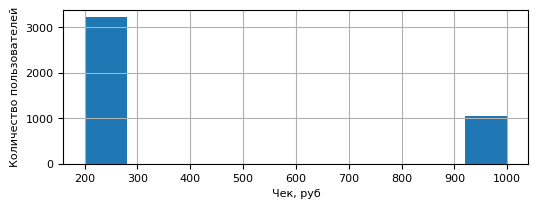

In [11]:
fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot()
ab_data.loc[ab_data.grp == 'A', 'price'].dropna().hist()
ax.set_xlabel('Чек, руб', fontsize=8)
ax.set_ylabel('Количество пользователей', fontsize=8)
ax.tick_params(labelsize=8)
plt.show()

Проверим распределение средних чеков на нормальность с помощью теста Шапиро-Вилка.

In [12]:
w, p = stats.shapiro(ab_data.loc[ab_data.grp == 'A', 'price'].dropna())
print('w-статистика:', w)
print('p-value:', p.round(5))

w-статистика: 0.5343790347375128
p-value: 0.0


И визуальный анализ, и тест Шапиро-Вилка на нормальность говорят нам, что распределение не является нормальным.

Так как распределения признаков не бинарные (0-1) и не нормальные, нужно использовать для сравнения средних не только T-тест, но и непараметрический U-тест Манна-Уитни.\
\
U-тест сообщит нам, различаются ли сами распределения, а T-тест покажет, различаются ли средние этих распределений. При сравнении средних величин (например, ARPU) обычно важнее показатель p-значение для Т-теста: если он меньше 0,05, а p-значение теста Манна-Уитни больше 0,05, то это всё равно говорит о значимых различиях показателей.

#### Сравнение среднего чека

<b>Постановка гипотезы</b>
- H0: средний чек в группе А = средний чек в группе В
- H1: средний чек в группе A > средний чек в группе B т.е средний чек в В упал 

<b>Наблюдения</b>
- выборочное среднее чека в группе А = 396.12
- выборочное среднее чека в группе В = 348.8
- Нет оснований полагать, что истинные стандартные отклонения чека в A и B равны. 

Если гипотеза H0 верна, тогда разность выборочных средних чека распределена нормально с истинным матожиданием равным нулю и неизвестным нам истинным стандартным отклонением (по ЦПТ при достаточно большом n выборки ее выборочное среднее распределено нормально). 
Исходя из этого мы можем найти t-статистику и соответствующее p-value. Также дополнительно проводим U-тест.

В качестве уровня значимости альфа возьмем 0,05. 

In [13]:
bills_A = ab_data.loc[ab_data.grp == 'A', 'price'].dropna(axis=0)
bills_B = ab_data.loc[ab_data.grp == 'B', 'price'].dropna(axis=0)

# alternative='greater' потому что альтернативная гипотеза H1 звучит как "разность средних значений чеков А и В БОЛЬШЕ чем ноль"
u_bill = stats.mannwhitneyu(bills_A, bills_B, alternative='greater')

# usevar='unequal' потому что нет оснований полагать, что истинные средние отклонения в А и В равны 
# alternative='larger' потому что альтернативная гипотеза H1 звучит как "разность средних значений чеков А и В БОЛЬШЕ чем ноль"
t_bill = weightstats.ttest_ind(bills_A, bills_B, usevar='unequal', alternative='larger')

print('U-статистика:', u_bill[0], '\t', 'p-value:', u_bill[1])
print('T-статистика:', t_bill[0], '\t', 'p-value:', t_bill[1].round(5))

U-статистика: 28984683.0 	 p-value: 0.0
T-статистика: 7.94539553459362 	 p-value: 0.0


<b>Вывод о среднем чеке</b>\
Оба теста показали очень маленькое p-value, гораздо меньшее чем 0.05, что говорит о том, что если бы истинные матожидания чеков в А и В были бы равны, то вероятность получить наши наблюдаемые выборочные значения среднего чека была бы очень сильно мала, поэтому мы отвергаем нулевую гипотезу о равенстве средних чеков в пользу альтернативной и считаем, что средний чек в А действительно значимо больше чем в В.

#### <u>2.3) ARPU</u><a id="arpu"></a>
Рассчитаем значимость различия средней выручки на пользователя групп A и B.

У нас весьма небольшое количество цен на подписки, поэтому очевидно, что средняя выручка на пользователя не будут распределена нормально. Визуализируем распределение средних чеков.

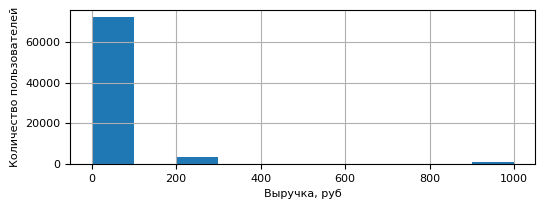

In [14]:
fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot()
ab_data.loc[ab_data.grp == 'A', 'price'].fillna(0).hist()
ax.set_xlabel('Выручка, руб', fontsize=8)
ax.set_ylabel('Количество пользователей', fontsize=8)
ax.tick_params(labelsize=8)
plt.show()

Проверим распределение средней выручки на человека на нормальность с помощью теста Шапиро-Вилка.

In [15]:
w, p = stats.shapiro(ab_data.loc[ab_data.grp == 'A', 'price'].fillna(0))
print('w-статистика:', w)
print('p-value:', p.round(5))

w-статистика: 0.17147488625043594
p-value: 0.0


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 76605.
  res = hypotest_fun_out(*samples, **kwds)


И визуальный анализ, и тест Шапиро-Вилка на нормальность говорят нам, что распределение не является нормальным.

Так как распределения признаков не бинарные (0-1) и не нормальные, нужно использовать для сравнения средних не только T-тест, но и непараметрический U-тест Манна-Уитни.\
\
U-тест сообщит нам, различаются ли сами распределения, а T-тест покажет, различаются ли средние этих распределений. При сравнении средних величин (например, ARPU) обычно важнее показатель p-значение для Т-теста: если он меньше 0,05, а p-значение теста Манна-Уитни больше 0,05, то это всё равно говорит о значимых различиях показателей.

#### Сравнение ARPU

<b>Постановка гипотезы</b>
- H0: ARPU в группе А = ARPU в группе В
- H1: ARPU в группе A < ARPU в группе B т.е ARPU в В выросло

<b>Наблюдения</b>
- выборочное ARPU в группе А = 22.13
- выборочное ARPU в группе В = 42.91
- Нет оснований полагать, что истинные стандартные отклонения доходов с каждого пользователя в A и B равны. 

Если гипотеза H0 верна, тогда разность выборочных ARPU в А и В распределена нормально с истинным матожиданием равным нулю и неизвестным нам истинным стандартным отклонением(по ЦПТ при достаточно большом n выборки ее выборочное среднее распределено нормально). 
Исходя из этого мы можем найти t статистику и соответствующее p-value. Также дополнительно проводим U-тест

В качестве уровня значимости альфа возьмем 0,05. 



In [16]:
ARPU_A = ab_data.loc[ab_data.grp == 'A', 'price'].fillna(0)
ARPU_B = ab_data.loc[ab_data.grp == 'B', 'price'].fillna(0)

# alternative='less' потому что альтернативная гипотеза H1 звучит как "разность ARPU А и В МЕНЬШЕ чем ноль"
u_arpu = stats.mannwhitneyu(ARPU_A, ARPU_B, alternative='less')

# usevar='unequal' потому чтро нет оснований полагать, что истинные средние отклонения в А и В равны 
# alternative='smaller' потому что альтернативная гипотеза H1 звучит как "разность ARPU А и В МЕНЬШЕ чем ноль"
t_arpu = weightstats.ttest_ind(ARPU_A, ARPU_B, usevar='unequal', alternative='smaller')

print('U-статистика:', u_arpu[0], '\t', 'p-value:', u_arpu[1].round(5))
print('T-статистика:', t_arpu[0].round(9), '\t', 'p-value:', t_arpu[1].round(5))

U-статистика: 2746687083.0 	 p-value: 0.0
T-статистика: -29.894186199 	 p-value: 0.0


<b>Вывод об ARPU</b>\
Оба теста показали очень маленькое p-value, гораздо меньшее чем 0.05, что говорит о том, что если бы истинные матожидания дохода с каждого пользователя в А и В были бы равны, то вероятность получить наши наблюдаемые выборочные ARPU была бы очень сильно мала, поэтому мы отвергаем нулевую гипотезу о равенстве ARPU в А и В и считаем, что ARPU в B действительно значимо больше чем в A.

#### <u>3) Доверительные интервалы</u><a id="ci"></a>

Интервал в котором «скорее всего» лежит истинное значение.\
(Например: с 95%-ной вероятностью в нашем интервале лежит реальное значение, и лишь в 5 % случаев мы ошибаемся).

Показывает, насколько параметры из выборочной совокупности могут отличаться от реально существующих данных в генеральной совокупности. Насколько мы ошибаемся при формировании той или иной выборки, мы закладываем в так называемую ошибку репрезентативности, в ошибку средней и вокруг нее собственно и строим доверительный интервал.

Уровень значимости связан с доверительным интервалом и отражает степень нашей уверенности, что истинное значение находится внутри данного доверительного интервала. Чем меньше уровень значимости, тем мы более уверены.

Посчитаем 95% доверительные интервалы для конверсии, ARPU и среднего чека. 

In [17]:
#Функции для получения доверительных интервалов

# Считает доверительные интервалы для средних
def get_conf_interval(data, conf_level = 0.95):  
        buf = (stats.t.interval(conf_level, len(data),
                             loc=np.mean(data), scale=stats.sem(data)))
        # возвращаем предел погрешности
        return float((buf[1] - buf[0])/2)
    
#Считает доверительные интервалы для бинарных величин
def get_conf_interval_z(succ, tot):  
    buf = proportion_confint(succ, tot)
    # возвращаем предел погрешности
    return buf[1] - buf[0]

In [111]:
#Доверительные интервалы
conf_conv_A = get_conf_interval_z(ab_data.loc[ab_data.grp == 'A', 'price'].dropna(axis=0).count(), 
                                            ab_data.loc[ab_data.grp == 'A', 'user_id'].count())
conf_conv_B = get_conf_interval_z(ab_data.loc[ab_data.grp == 'B', 'price'].dropna(axis=0).count(), 
                                            ab_data.loc[ab_data.grp == 'B', 'user_id'].count())

conf_bill_A = get_conf_interval(ab_data.loc[ab_data.grp == 'A', 'price'].dropna(axis=0))
conf_bill_B = get_conf_interval(ab_data.loc[ab_data.grp == 'B', 'price'].dropna(axis=0))

conf_ARPU_A = get_conf_interval(ab_data.loc[ab_data.grp == 'A', 'price'].fillna(0))
conf_ARPU_B = get_conf_interval(ab_data.loc[ab_data.grp == 'B', 'price'].fillna(0))

print('Доверительные интервалы:')
print('Конверсия группы A:', f'± {conf_conv_A:.3f}')
print('Конверсия группы A:', f'± {conf_conv_B:.3f}')                             
print('Средний чек группы A:', f'± {conf_bill_A:.2f}')
print('Средний чек группы A:', f'± {conf_bill_B:.2f}')
print('ARPU группы A:', f'± {conf_ARPU_A:.2f}')
print('ARPU группы B:', f'± {conf_ARPU_B:.2f}')

Доверительные интервалы:
Конверсия группы A: ± 0.003
Конверсия группы A: ± 0.005
Средний чек группы A: ± 10.32
Средний чек группы A: ± 5.47
ARPU группы A: ± 0.86
ARPU группы B: ± 1.05


#### <u>4) Отчёт</u><a id="sum"></a>

[Text(0, 0, '0'), Text(0, 0, '1,592,693')]

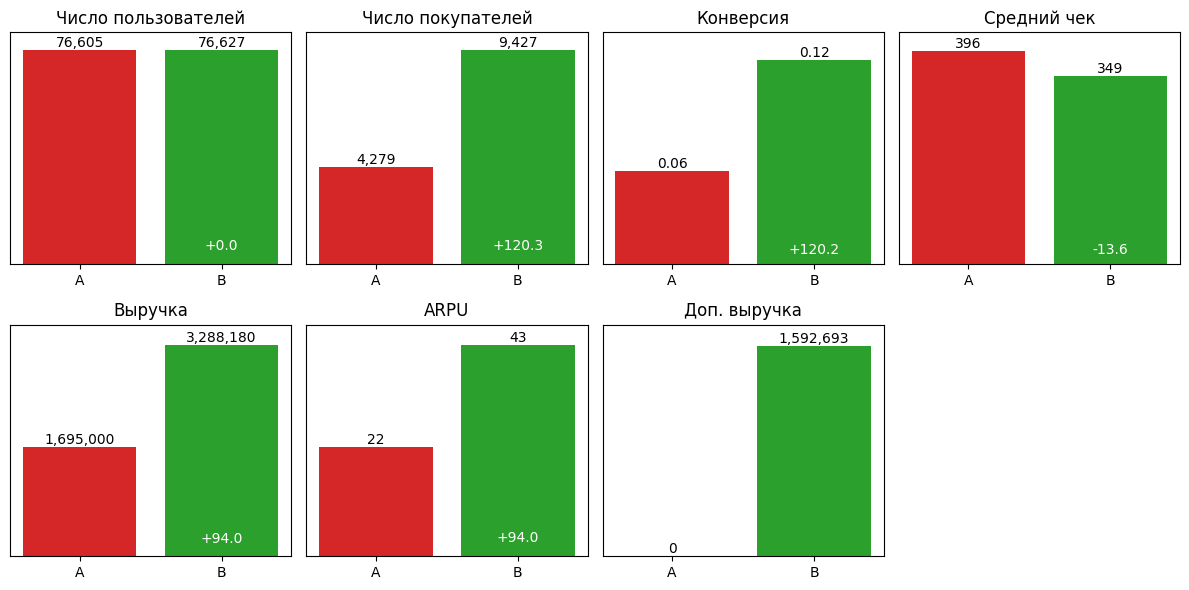

In [110]:
fig = plt.figure(tight_layout=True, figsize=[12, 6])

ax1 = fig.add_subplot(2, 4, 1)  # Строки, столбцы, квадрант
ax2 = fig.add_subplot(2, 4, 2)
ax3 = fig.add_subplot(2, 4, 3)
ax4 = fig.add_subplot(2, 4, 4)
ax5 = fig.add_subplot(2, 4, 5)
ax6 = fig.add_subplot(2, 4, 6)
ax7 = fig.add_subplot(2, 4, 7)

bar_container = ax1.bar(['A', 'B'], [ab_summary.users_count.A, ab_summary.users_count.B], color=['tab:red', 'tab:green'])
ax1.set(title='Число пользователей', yticks=([]), ylim=[0, 83000])
ax1.bar_label(bar_container, fmt='{:,.0f}')
ax1.text(1, 5000, s=f'{ab_summary['UC, %']['B']}', color='white', horizontalalignment='center')

bar_container = ax2.bar(['A', 'B'], [ab_summary.buyers_count.A, ab_summary.buyers_count.B], color=['tab:red', 'tab:green'])
ax2.set(title='Число покупателей', yticks=([]), ylim=[0, 10200])
ax2.bar_label(bar_container, fmt='{:,.0f}')
ax2.text(1, 600, s=f'{ab_summary['BC, %']['B']}', color='white', horizontalalignment='center')

bar_container = ax3.bar(['A', 'B'], [ab_summary.conversion.A, ab_summary.conversion.B], color=['tab:red', 'tab:green'])
ax3.set(title='Конверсия', yticks=([]), ylim=[0, 0.14])
ax3.bar_label(bar_container, fmt='{:.2f}')
ax3.text(1, 0.006, s=f'{ab_summary['C, %']['B']}', color='white', horizontalalignment='center')

bar_container = ax4.bar(['A', 'B'], [ab_summary.avg_bill.A, ab_summary.avg_bill.B], color=['tab:red', 'tab:green'])
ax4.set(title='Средний чек', yticks=([]), ylim=[0, 430])
ax4.bar_label(bar_container, fmt='{:,.0f}')
ax4.text(1, 18, s=f'{ab_summary['AB, %']['B']}', color='white', horizontalalignment='center')

bar_container = ax5.bar(['A', 'B'], [ab_summary.revenue.A, ab_summary.revenue.B], color=['tab:red', 'tab:green'])
ax5.set(title='Выручка', yticks=([]), ylim=[0, 3600000])
ax5.bar_label(bar_container, fmt='{:,.0f}')
ax5.text(1, 200000, s=f'{ab_summary['R, %']['B']}', color='white', horizontalalignment='center')

bar_container = ax6.bar(['A', 'B'], [ab_summary.ARPU.A, ab_summary.ARPU.B], color=['tab:red', 'tab:green'])
ax6.set(title='ARPU', yticks=([]), ylim=[0, 47])
ax6.bar_label(bar_container, fmt='{:,.0f}')
ax6.text(1, 3, s=f'{ab_summary['A, %']['B']}', color='white', horizontalalignment='center')

bar_container = ax7.bar(['A', 'B'], [0, ab_summary.add_rev.B], color=['tab:red', 'tab:green'])
ax7.set(title='Доп. выручка', yticks=([]), ylim=[0, 1750000])
ax7.bar_label(bar_container, fmt='{:,.0f}')

#### <u>5) Выводы</u><a id="fin"></a>

1. Тест значимо увеличил ARPU на 94%
2. Тест значимо уменьшил средний чек на 13,6%
3. Тест значимо увеличил конверсию на 120%
4. Дополнительная выручка составила 1,59 млн.руб.\
\
<b>Таким образом, скидки способствуют мгновенному увеличению выручки, поэтому их можно проводить время от времени.</b>